<h1>Install Atari and visualization dependencies<h1>

In [ ]:
# Install Gymnasium with full Atari support and auto-accept ROM license
!pip install "gymnasium[atari, accept-rom-license]"

# Install Shimmy to provide compatibility between different Gym environments
!pip install shimmy

# Install Pygame and ImageIO for rendering environments and saving video output
!pip install pygame imageio

!pip install seaborn

<h1>Importing Required Libraries<h1>

In [2]:
import gymnasium as gym  # Library for reinforcement learning environments
import numpy as np  # Numerical computations for array operations
import torch  # PyTorch for neural network implementation
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimizer for training
import torch.nn.functional as F  # Functional operations like ReLU
from collections import deque, namedtuple  # Data structures for replay buffer
import random  # Random sampling for exploration
import matplotlib.pyplot as plt  # Plotting training results
try:
    import seaborn as sns  # Enhanced plotting aesthetics
    seaborn_available = True
except ImportError:
    seaborn_available = False  # Flag to handle missing Seaborn
from tqdm import tqdm  # Progress bar for training loops
import ale_py  # Atari Learning Environment support
import uuid  # For generating unique artifact IDs

<h1>🎨 Configure Plotting Style for Enhanced Visualization<h1>

In [ ]:
if seaborn_available:
    sns.set_palette("deep")  # Use Seaborn's deep color palette if available
    plt.style.use('seaborn-v0_8')  # Use Seaborn's modern style (compatible with Matplotlib 3.6+)
else:
    plt.style.use('bmh')  # Use Matplotlib's bmh style for a vibrant, modern look
    # Define a custom vibrant color palette for attractive plots
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072B2', '#D55E00', '#009E73', '#CC79A7'])
    # Enhance plot aesthetics
    plt.rcParams.update({
        'axes.facecolor': '#F5F5F5',  # Light background for contrast
        'axes.edgecolor': '#333333',  # Darker edges for clarity
        'font.size': 12,  # Increase font size for readability
        'grid.linestyle': ':',  # Dotted grid for a cleaner look
        'grid.alpha': 0.6,  # Subtle grid transparency
        'figure.facecolor': '#FFFFFF',  # White figure background
    })

<h1>🎮 Environment Setup – Tennis (Atari) Environment Wrapper<h1>

In [ ]:
class TennisEnvironment:
    """Manages the Tennis game environment from Gymnasium."""
    def __init__(self):
        """Initialize the Tennis environment with RGB rendering."""
        self.env = gym.make('ALE/Tennis-v5', render_mode='rgb_array')  # Create Atari Tennis environment

    def reset(self):
        """Reset the environment to initial state.

        Returns:
            numpy.ndarray: Initial state observation.
        """
        state, _ = self.env.reset()  # Reset environment and get initial state
        return state

    def step(self, action):
        """Execute an action in the environment.

        Args:
            action (int): Action to take in the environment.

        Returns:
            tuple: Next state, reward, done flag, and additional info.
        """
        next_state, reward, terminated, truncated, info = self.env.step(action)  # Perform action
        return next_state, reward, terminated or truncated, info  # Return step results

<h1>🧠 Neural Network Architecture – Deep Q-Network (DQN)<h1>

In [ ]:
class DeepQNetwork(nn.Module):
    """Neural network architecture for the Deep Q-Network."""
    def __init__(self, input_size, output_size, hidden_size=128):
        """Initialize the DQN with three fully connected layers.

        Args:
            input_size (int): Size of the input state vector.
            output_size (int): Number of possible actions.
            hidden_size (int): Number of neurons in hidden layers.
        """
        super(DeepQNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  # Input to first hidden layer
        self.layer2 = nn.Linear(hidden_size, hidden_size)  # Hidden to hidden layer
        self.layer3 = nn.Linear(hidden_size, output_size)  # Hidden to output layer

    def forward(self, x):
        """Forward pass through the network.

        Args:
            x (torch.Tensor): Input state tensor.

        Returns:
            torch.Tensor: Q-values for each action.
        """
        x = F.relu(self.layer1(x))  # Apply ReLU activation after first layer
        x = F.relu(self.layer2(x))  # Apply ReLU activation after second layer
        return self.layer3(x)  # Output Q-values

<h1>🧩 Experience Replay Buffer — For Deep Q-Networks (DQN)<h1>

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ExperienceReplay:
    """Stores and samples experiences for training the DQN."""
    def __init__(self, capacity):
        """Initialize the replay buffer with fixed capacity.

        Args:
            capacity (int): Maximum number of experiences to store.
        """
        self.memory = deque(maxlen=capacity)  # Initialize deque with max length

    def add(self, *args):
        """Add a new experience to the buffer.

        Args:
            *args: State, action, next_state, reward, done tuple.
        """
        self.memory.append(Transition(*args))  # Store transition in memory

    def sample(self, batch_size):
        """Sample a random batch of experiences.

        Args:
            batch_size (int): Number of experiences to sample.

        Returns:
            list: Randomly sampled transitions.
        """
        return random.sample(self.memory, batch_size)  # Randomly select transitions

    def __len__(self):
        """Return the current size of the buffer.

        Returns:
            int: Number of stored experiences.
        """
        return len(self.memory)

<h1>🧠 Deep Q-Network (DQN) Agent Implementation<h1>

In [ ]:
class DQNAgent:
    """Implements the DQN agent with exploration and learning capabilities."""
    def __init__(self, state_size, action_size, hidden_size=128, learning_rate=5e-4,
                 discount_factor=0.995, epsilon_start=1.0, epsilon_min=0.01,
                 epsilon_decay_steps=15000, replay_capacity=50000, batch_size=64,
                 target_update_freq=500, use_double_dqn=False):
        """Initialize the DQN agent with policy and target networks.

        Args:
            state_size (int): Size of the state vector.
            action_size (int): Number of possible actions.
            hidden_size (int): Number of neurons in hidden layers.
            learning_rate (float): Learning rate for the optimizer.
            discount_factor (float): Discount factor for future rewards.
            epsilon_start (float): Initial epsilon for exploration.
            epsilon_min (float): Minimum epsilon value.
            epsilon_decay_steps (int): Steps for epsilon decay.
            replay_capacity (int): Replay buffer capacity.
            batch_size (int): Batch size for training.
            target_update_freq (int): Frequency of target network updates.
            use_double_dqn (bool): Whether to use Double DQN.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = discount_factor
        self.epsilon_start = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay_steps
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.use_double_dqn = use_double_dqn
        self.steps_taken = 0

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Select GPU if available

        # Initialize policy and target networks
        self.policy_network = DeepQNetwork(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DeepQNetwork(state_size, action_size, hidden_size).to(self.device)
        self.target_network.load_state_dict(self.policy_network.state_dict())  # Copy weights to target
        self.target_network.eval()  # Set target network to evaluation mode

        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=learning_rate)  # Adam optimizer
        self.replay_buffer = ExperienceReplay(replay_capacity)  # Initialize replay buffer

    def select_action(self, state):
        """Choose an action using epsilon-greedy strategy.

        Args:
            state (torch.Tensor): Current state tensor.

        Returns:
            torch.Tensor: Selected action.
        """
        self.steps_taken += 1  # Increment step counter
        # Calculate current epsilon for exploration
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * \
                       np.exp(-1. * self.steps_taken / self.epsilon_decay)

        if random.random() < self.epsilon:  # Explore: select random action
            return torch.tensor([[random.randrange(self.action_size)]], device=self.device, dtype=torch.long)

        with torch.no_grad():  # Exploit: select action with highest Q-value
            return self.policy_network(state).max(1)[1].view(1, 1)

    def train_step(self):
        """Perform one training step using a batch from the replay buffer."""
        if len(self.replay_buffer) < self.batch_size:  # Skip if not enough experiences
            return

        # Sample a batch of transitions
        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # Create mask for non-final states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                      device=self.device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(self.device)

        # Prepare batch tensors
        state_batch = torch.cat(batch.state).to(self.device)
        action_batch = torch.cat(batch.action).to(self.device)
        reward_batch = torch.cat(batch.reward).to(self.device)

        # Compute current Q-values
        q_values = self.policy_network(state_batch).gather(1, action_batch)

        # Compute target Q-values
        next_q_values = torch.zeros(self.batch_size, device=self.device)
        if self.use_double_dqn:  # Double DQN: use policy network for action selection
            next_actions = self.policy_network(non_final_next_states).max(1)[1].unsqueeze(1)
            next_q_values[non_final_mask] = self.target_network(non_final_next_states).gather(1, next_actions).squeeze(1).detach()
        else:  # Standard DQN: use target network for max Q-value
            next_q_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0].detach()

        # Calculate expected Q-values
        expected_q_values = (next_q_values * self.discount_factor) + reward_batch
        loss = F.smooth_l1_loss(q_values, expected_q_values.unsqueeze(1))  # Compute loss

        # Optimize the policy network
        self.optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Backpropagate loss
        for param in self.policy_network.parameters():  # Clip gradients
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()  # Update weights

        # Update target network periodically
        if self.steps_taken % self.target_update_freq == 0:
            self.target_network.load_state_dict(self.policy_network.state_dict())

<h1>⚙️ Utility Functions for DQN Training<h1>

In [ ]:
def preprocess_state(state):
    """Convert RGB state to grayscale, normalize, and flatten it.

    Args:
        state (numpy.ndarray): Raw RGB observation from the environment.

    Returns:
        torch.Tensor: Preprocessed state tensor.
    """
    state = np.array(state).mean(axis=2).astype(np.float32) / 255.0  # Convert to grayscale and normalize
    return torch.FloatTensor(state).flatten().unsqueeze(0)  # Flatten and add batch dimension

def train_dqn_agent(environment, agent, num_episodes=1000, max_steps_per_episode=1000, moving_avg_window=150):
    """Train the DQN agent and track rewards.

    Args:
        environment (TennisEnvironment): The game environment.
        agent (DQNAgent): The DQN agent to train.
        num_episodes (int): Number of episodes to train.
        max_steps_per_episode (int): Maximum steps per episode.
        moving_avg_window (int): Window size for moving average.

    Returns:
        tuple: Lists of episode rewards and moving averages.
    """
    if environment is None or agent is None:
        raise ValueError("Environment and agent must be initialized.")

    episode_rewards = []  # Store rewards for each episode
    moving_averages = []  # Store moving averages of rewards

    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        state = preprocess_state(environment.reset()).to(agent.device)  # Reset environment
        total_reward = 0  # Track total reward for episode

        for step in range(max_steps_per_episode):
            action = agent.select_action(state)  # Select action
            next_state, reward, done, _ = environment.step(action.item())  # Execute action
            next_state = preprocess_state(next_state).to(agent.device) if not done else None  # Preprocess next state

            # Store experience in replay buffer
            agent.replay_buffer.add(state, action, next_state,
                                   torch.tensor([reward], device=agent.device),
                                   torch.tensor([done], device=agent.device))

            # Update state for next step
            state = next_state if next_state is not None else preprocess_state(environment.reset()).to(agent.device)
            total_reward += reward  # Accumulate reward

            agent.train_step()  # Perform training step

            if done:  # Exit loop if episode is complete
                break

        episode_rewards.append(total_reward)  # Record episode reward
        # Calculate moving average
        moving_averages.append(np.mean(episode_rewards[-moving_avg_window:]) if episode >= moving_avg_window - 1
                              else np.mean(episode_rewards))

    return episode_rewards, moving_averages

def plot_training_results(rewards, moving_avg, title, moving_avg_window):
    """Visualize training progress with rewards and moving average in a stylized manner.

    Args:
        rewards (list): List of episode rewards.
        moving_avg (list): List of moving averages.
        title (str): Plot title.
        moving_avg_window (int): Window size for moving average.
    """
    plt.figure(figsize=(14, 7), facecolor='#F8F9FA')  # Create figure with larger size and light background
    ax = plt.gca()  # Get current axis
    ax.set_facecolor('#E6F0FA')  # Set subtle blue-gray background for contrast

    # Plot episode rewards with vibrant color and slight transparency
    plt.plot(rewards, alpha=0.5, label='Episode Reward', color='#005566', linewidth=1.5)
    # Plot moving average with bold, contrasting color
    plt.plot(moving_avg, label=f'Moving Average (window={moving_avg_window})', color='#FF6B35', linewidth=2.5)

    # Customize labels and title with larger, bold fonts
    plt.xlabel('Episode', fontsize=14, weight='bold')
    plt.ylabel('Reward', fontsize=14, weight='bold')
    plt.title(title, fontsize=16, weight='bold', pad=15)

    # Add a styled legend with shadow
    plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, facecolor='#FFFFFF', edgecolor='#333333')

    # Customize grid with subtle dotted style
    plt.grid(True, linestyle=':', alpha=0.5, color='#666666')

    # Adjust layout for clean presentation
    plt.tight_layout()

    # Save plot with a descriptive filename
    plt.savefig(f'{title.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')

    # Display plot
    plt.show()

    # Close figure to free memory
    plt.close()

<h1>⚡ Experiment Functions for DQN & Double DQN<h1>

In [ ]:
def run_part_a():
    """Run DQN experiments with different hyperparameter sets."""
    # Initialize environment
    env = TennisEnvironment()
    sample_state = preprocess_state(env.env.observation_space.sample())  # Sample state for size
    state_size = sample_state.shape[1]  # Get state dimension
    action_size = env.env.action_space.n  # Get action space size

    # Define hyperparameter sets
    hyperparams = [
        {'hidden_size': 128, 'learning_rate': 5e-4, 'epsilon_decay_steps': 7500, 'batch_size': 64},
        {'hidden_size': 256, 'learning_rate': 3e-4, 'epsilon_decay_steps': 15000, 'batch_size': 128},
        {'hidden_size': 512, 'learning_rate': 1e-4, 'epsilon_decay_steps': 30000, 'batch_size': 256}
    ]

    for i, params in enumerate(hyperparams):
        print(f"\nTraining DQN with Hyperparameters Set {i+1}: {params}")
        agent = DQNAgent(state_size, action_size, **params)  # Initialize agent
        rewards, moving_avg = train_dqn_agent(env, agent, num_episodes=100, moving_avg_window=150)  # Train agent
        # Plot results with enhanced styling
        plt.figure(figsize=(14, 7), facecolor='#F8F9FA')  # Create figure with larger size and light background
        ax = plt.gca()  # Get current axis
        ax.set_facecolor('#E6F0FA')  # Set subtle blue-gray background
        plt.plot(rewards, alpha=0.5, label='Episode Reward', color='#005566', linewidth=1.5)  # Plot rewards
        plt.plot(moving_avg, label=f'Moving Average (window=150)', color='#FF6B35', linewidth=2.5)  # Plot moving average
        plt.xlabel('Episode', fontsize=14, weight='bold')  # Set x-axis label
        plt.ylabel('Reward', fontsize=14, weight='bold')  # Set y-axis label
        plt.title(f'DQN Performance - Set {i+1}', fontsize=16, weight='bold', pad=15)  # Set title
        plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, facecolor='#FFFFFF', edgecolor='#333333')  # Styled legend
        plt.grid(True, linestyle=':', alpha=0.5, color='#666666')  # Dotted grid
        plt.tight_layout()  # Adjust layout
        plt.savefig(f'dqn_performance_set_{i+1}.png', dpi=300, bbox_inches='tight')  # Save high-quality plot
        plt.show()  # Display plot
        plt.close()  # Close figure

def run_part_b():
    """Run Double DQN experiments with different hyperparameter sets."""
    # Initialize environment
    env = TennisEnvironment()
    sample_state = preprocess_state(env.env.observation_space.sample())  # Sample state for size
    state_size = sample_state.shape[1]  # Get state dimension
    action_size = env.env.action_space.n  # Get action space size

    # Define hyperparameter sets
    hyperparams = [
        {'hidden_size': 128, 'learning_rate': 5e-4, 'epsilon_decay_steps': 7500, 'batch_size': 64, 'use_double_dqn': True},
        {'hidden_size': 256, 'learning_rate': 3e-4, 'epsilon_decay_steps': 15000, 'batch_size': 128, 'use_double_dqn': True},
        {'hidden_size': 512, 'learning_rate': 1e-4, 'epsilon_decay_steps': 30000, 'batch_size': 256, 'use_double_dqn': True}
    ]

    for i, params in enumerate(hyperparams):
        print(f"\nTraining Double DQN with Hyperparameters Set {i+1}: {params}")
        agent = DQNAgent(state_size, action_size, **params)  # Initialize agent
        rewards, moving_avg = train_dqn_agent(env, agent, num_episodes=100, moving_avg_window=150)  # Train agent
        # Plot results with enhanced styling
        plt.figure(figsize=(14, 7), facecolor='#F8F9FA')  # Create figure with larger size and light background
        ax = plt.gca()  # Get current axis
        ax.set_facecolor('#E6F0FA')  # Set subtle blue-gray background
        plt.plot(rewards, alpha=0.5, label='Episode Reward', color='#005566', linewidth=1.5)  # Plot rewards
        plt.plot(moving_avg, label=f'Moving Average (window=150)', color='#FF6B35', linewidth=2.5)  # Plot moving average
        plt.xlabel('Episode', fontsize=14, weight='bold')  # Set x-axis label
        plt.ylabel('Reward', fontsize=14, weight='bold')  # Set y-axis label
        plt.title(f'Double DQN Performance - Set {i+1}', fontsize=16, weight='bold', pad=15)  # Set title
        plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, facecolor='#FFFFFF', edgecolor='#333333')  # Styled legend
        plt.grid(True, linestyle=':', alpha=0.5, color='#666666')  # Dotted grid
        plt.tight_layout()  # Adjust layout
        plt.savefig(f'double_dqn_performance_set_{i+1}.png', dpi=300, bbox_inches='tight')  # Save high-quality plot
        plt.show()  # Display plot
        plt.close()  # Close figure

def run_part_c(dqn_params, double_dqn_params):
    """Compare the best DQN and Double DQN configurations."""
    # Initialize environment
    env = TennisEnvironment()
    sample_state = preprocess_state(env.env.observation_space.sample())  # Sample state for size
    state_size = sample_state.shape[1]  # Get state dimension
    action_size = env.env.action_space.n  # Get action space size

    # Train DQN
    print("\nTraining Best DQN Configuration...")
    dqn_agent = DQNAgent(state_size, action_size, **dqn_params)  # Initialize DQN agent
    dqn_rewards, dqn_moving_avg = train_dqn_agent(env, dqn_agent, num_episodes=100, moving_avg_window=150)  # Train DQN
    # Plot DQN results with enhanced styling
    plt.figure(figsize=(14, 7), facecolor='#F8F9FA')  # Create figure with larger size and light background
    ax = plt.gca()  # Get current axis
    ax.set_facecolor('#E6F0FA')  # Set subtle blue-gray background
    plt.plot(dqn_rewards, alpha=0.5, label='Episode Reward', color='#005566', linewidth=1.5)  # Plot rewards
    plt.plot(dqn_moving_avg, label='Moving Average (window=150)', color='#FF6B35', linewidth=2.5)  # Plot moving average
    plt.xlabel('Episode', fontsize=14, weight='bold')  # Set x-axis label
    plt.ylabel('Reward', fontsize=14, weight='bold')  # Set y-axis label
    plt.title('Best DQN Performance', fontsize=16, weight='bold', pad=15)  # Set title
    plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, facecolor='#FFFFFF', edgecolor='#333333')  # Styled legend
    plt.grid(True, linestyle=':', alpha=0.5, color='#666666')  # Dotted grid
    plt.tight_layout()  # Adjust layout
    plt.savefig('best_dqn_performance.png', dpi=300, bbox_inches='tight')  # Save high-quality plot
    plt.show()  # Display plot
    plt.close()  # Close figure

    # Train Double DQN
    print("\nTraining Best Double DQN Configuration...")
    double_dqn_agent = DQNAgent(state_size, action_size, **double_dqn_params)  # Initialize Double DQN agent
    double_dqn_rewards, double_dqn_moving_avg = train_dqn_agent(env, double_dqn_agent, num_episodes=100, moving_avg_window=150)  # Train Double DQN
    # Plot Double DQN results with enhanced styling
    plt.figure(figsize=(14, 7), facecolor='#F8F9FA')  # Create figure with larger size and light background
    ax = plt.gca()  # Get current axis
    ax.set_facecolor('#E6F0FA')  # Set subtle blue-gray background
    plt.plot(double_dqn_rewards, alpha=0.5, label='Episode Reward', color='#005566', linewidth=1.5)  # Plot rewards
    plt.plot(double_dqn_moving_avg, label='Moving Average (window=150)', color='#FF6B35', linewidth=2.5)  # Plot moving average
    plt.xlabel('Episode', fontsize=14, weight='bold')  # Set x-axis label
    plt.ylabel('Reward', fontsize=14, weight='bold')  # Set y-axis label
    plt.title('Best Double DQN Performance', fontsize=16, weight='bold', pad=15)  # Set title
    plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, facecolor='#FFFFFF', edgecolor='#333333')  # Styled legend
    plt.grid(True, linestyle=':', alpha=0.5, color='#666666')  # Dotted grid
    plt.tight_layout()  # Adjust layout
    plt.savefig('best_double_dqn_performance.png', dpi=300, bbox_inches='tight')  # Save high-quality plot
    plt.show()  # Display plot
    plt.close()  # Close figure

    # Compute statistics
    dqn_mean, dqn_std = np.mean(dqn_rewards), np.std(dqn_rewards)  # Calculate DQN stats
    double_dqn_mean, double_dqn_std = np.mean(double_dqn_rewards), np.std(double_dqn_rewards)  # Calculate Double DQN stats

    print("\nComparison Results:")
    print(f"DQN - Mean Reward: {dqn_mean:.2f}, Std: {dqn_std:.2f}")
    print(f"Double DQN - Mean Reward: {double_dqn_mean:.2f}, Std: {double_dqn_std:.2f}")

    # Plot comparison with enhanced styling
    plt.figure(figsize=(14, 7), facecolor='#F8F9FA')  # Create figure with larger size and light background
    ax = plt.gca()  # Get current axis
    ax.set_facecolor('#E6F0FA')  # Set subtle blue-gray background
    plt.plot(dqn_rewards, alpha=0.5, label='DQN', color='#005566', linewidth=1.5)  # Plot DQN rewards with vibrant teal
    plt.plot(double_dqn_rewards, alpha=0.5, label='Double DQN', color='#FF6B35', linewidth=1.5)  # Plot Double DQN rewards with vibrant coral
    plt.xlabel('Episode', fontsize=14, weight='bold')  # Set x-axis label
    plt.ylabel('Reward', fontsize=14, weight='bold')  # Set y-axis label
    plt.title('DQN vs Double DQN Comparison', fontsize=16, weight='bold', pad=15)  # Set title
    plt.legend(fontsize=12, loc='best', frameon=True, shadow=True, facecolor='#FFFFFF', edgecolor='#333333')  # Styled legend
    plt.grid(True, linestyle=':', alpha=0.5, color='#666666')  # Dotted grid
    plt.tight_layout()  # Adjust layout
    plt.savefig('dqn_vs_double_dqn_comparison.png', dpi=300, bbox_inches='tight')  # Save high-quality plot
    plt.show()  # Display plot
    plt.close()  # Close figure

<h1>🏁 Main Execution<h1>

Running Part A: DQN Experiments

Training DQN with Hyperparameters Set 1: {'hidden_size': 128, 'learning_rate': 0.0005, 'epsilon_decay_steps': 7500, 'batch_size': 64}


Training Progress: 100%|██████████| 100/100 [10:34<00:00,  6.34s/it]


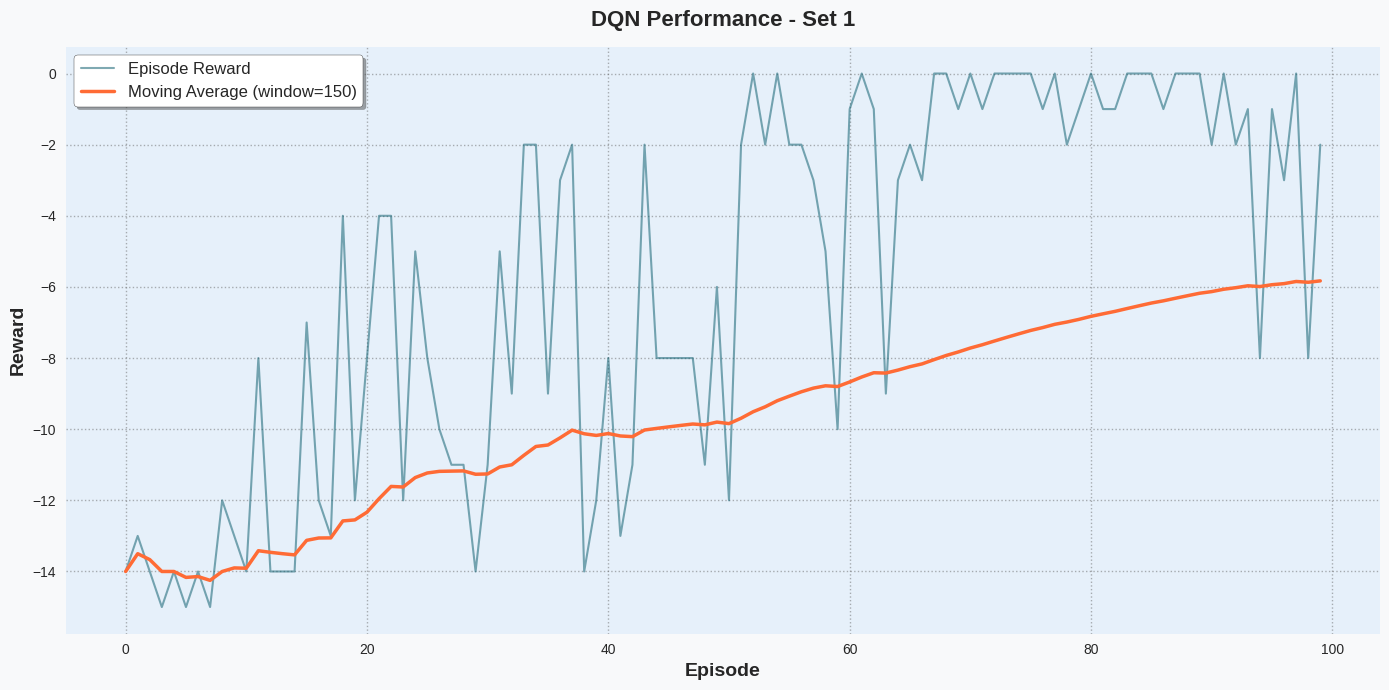


Training DQN with Hyperparameters Set 2: {'hidden_size': 256, 'learning_rate': 0.0003, 'epsilon_decay_steps': 15000, 'batch_size': 128}


Training Progress: 100%|██████████| 100/100 [14:37<00:00,  8.78s/it]


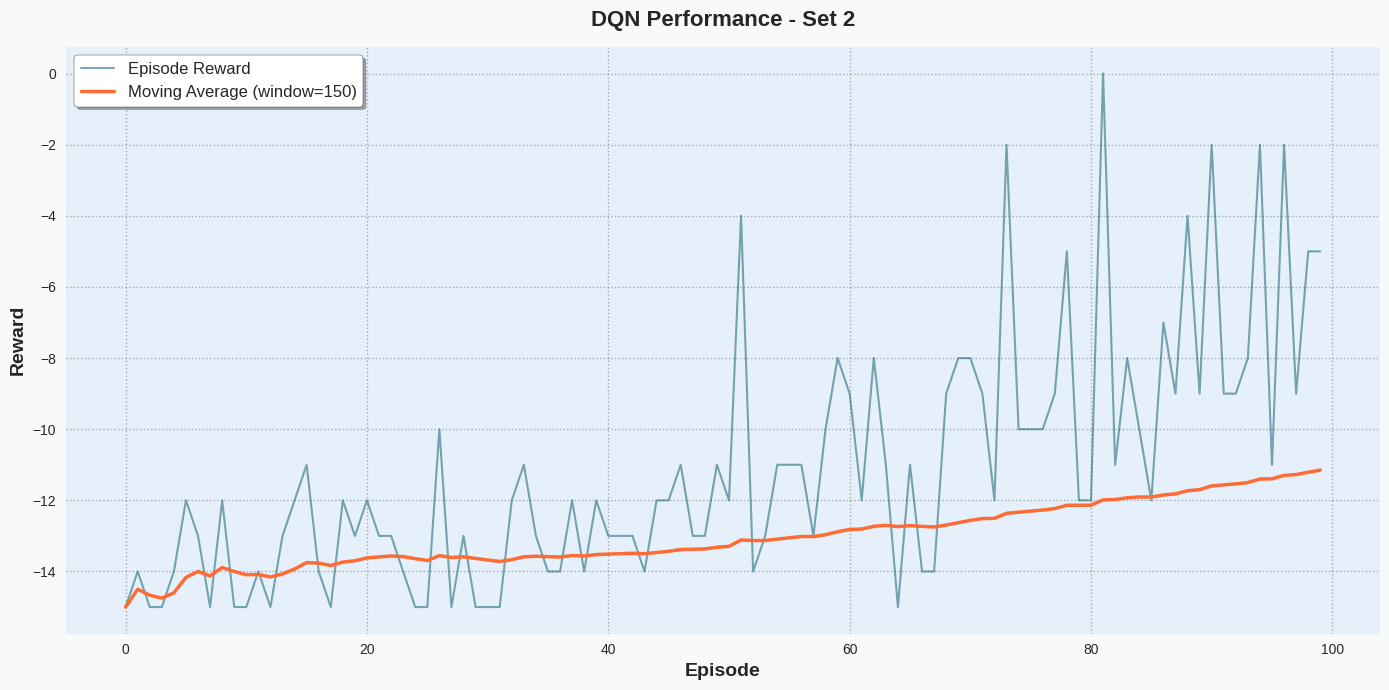


Training DQN with Hyperparameters Set 3: {'hidden_size': 512, 'learning_rate': 0.0001, 'epsilon_decay_steps': 30000, 'batch_size': 256}


Training Progress: 100%|██████████| 100/100 [26:51<00:00, 16.11s/it]


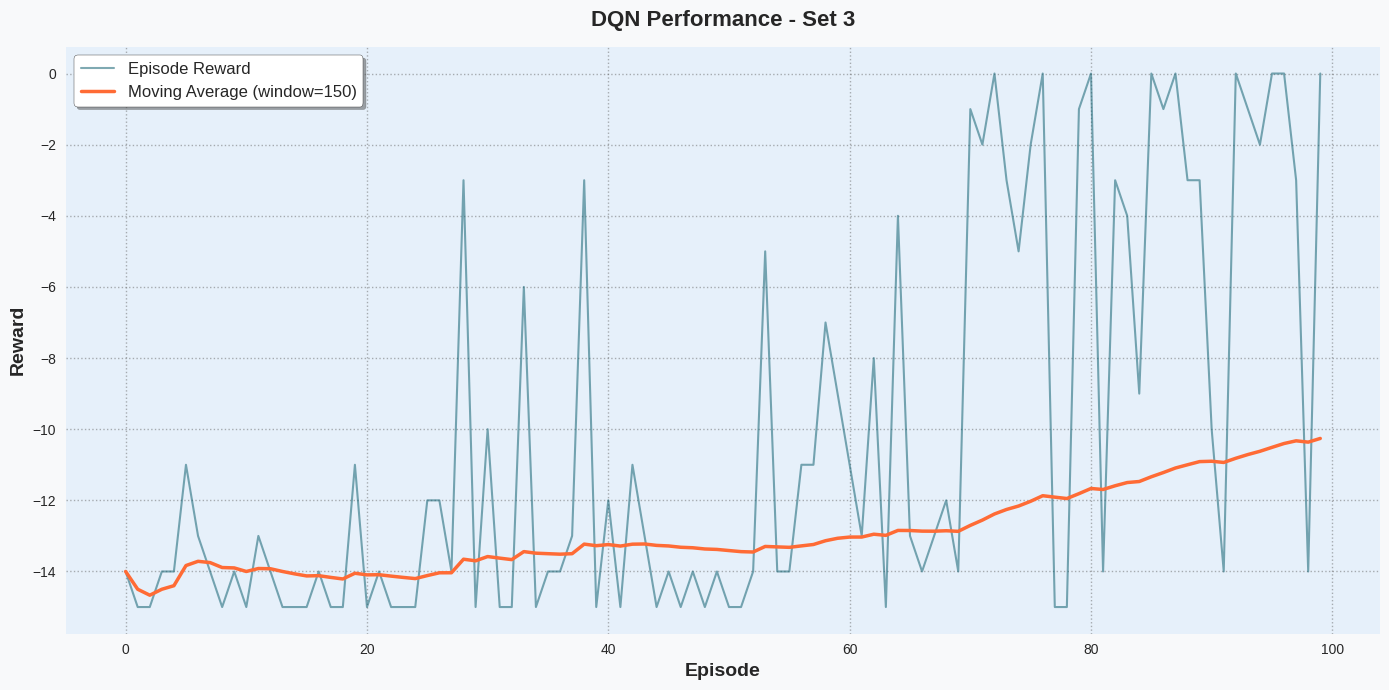


Running Part B: Double DQN Experiments

Training Double DQN with Hyperparameters Set 1: {'hidden_size': 128, 'learning_rate': 0.0005, 'epsilon_decay_steps': 7500, 'batch_size': 64, 'use_double_dqn': True}


Training Progress: 100%|██████████| 100/100 [11:11<00:00,  6.72s/it]


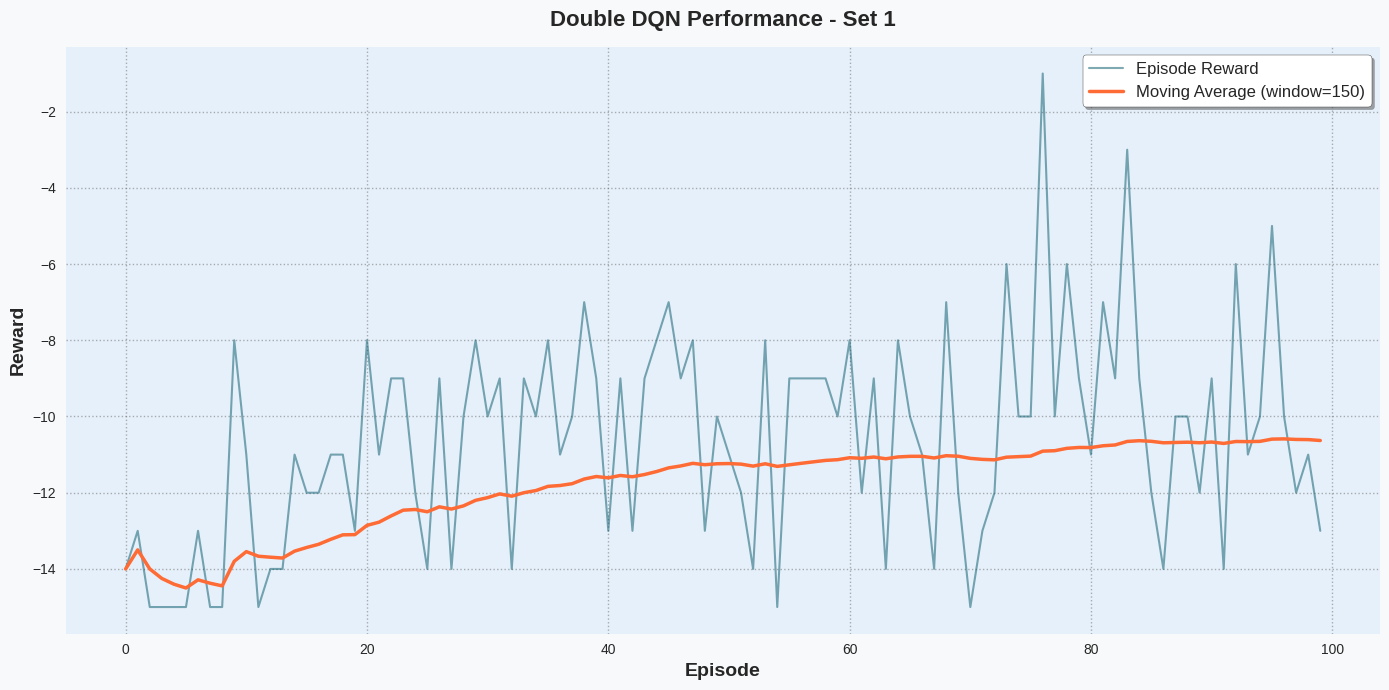


Training Double DQN with Hyperparameters Set 2: {'hidden_size': 256, 'learning_rate': 0.0003, 'epsilon_decay_steps': 15000, 'batch_size': 128, 'use_double_dqn': True}


Training Progress: 100%|██████████| 100/100 [15:39<00:00,  9.39s/it]


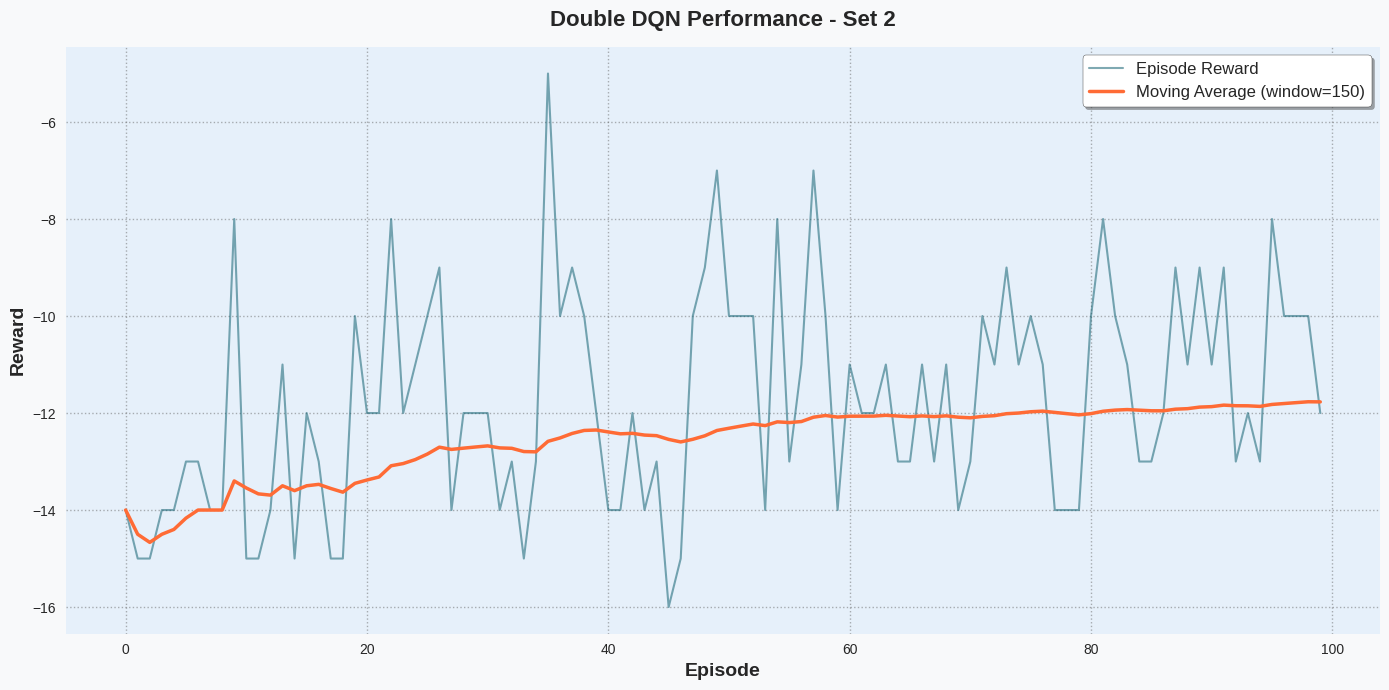


Training Double DQN with Hyperparameters Set 3: {'hidden_size': 512, 'learning_rate': 0.0001, 'epsilon_decay_steps': 30000, 'batch_size': 256, 'use_double_dqn': True}


Training Progress: 100%|██████████| 100/100 [30:44<00:00, 18.44s/it]


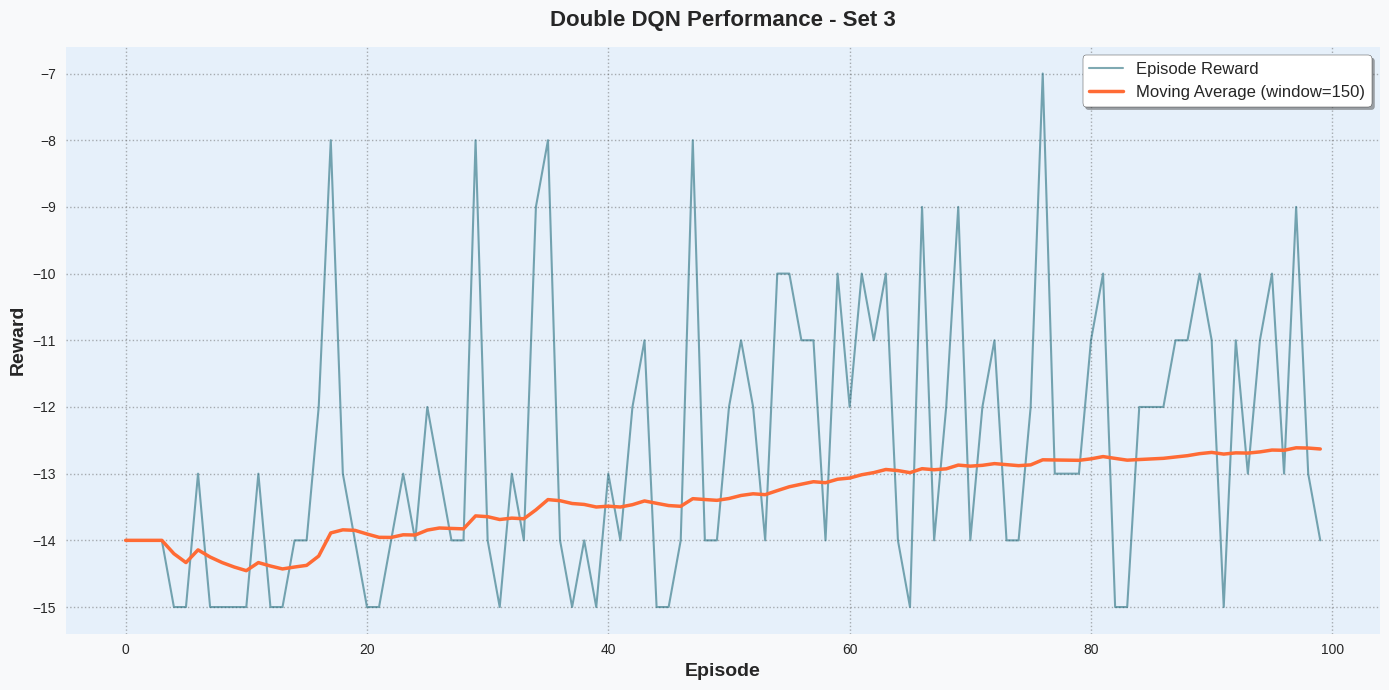


Running Part C: Comparison of Best DQN and Double DQN

Training Best DQN Configuration...


Training Progress: 100%|██████████| 100/100 [14:29<00:00,  8.70s/it]


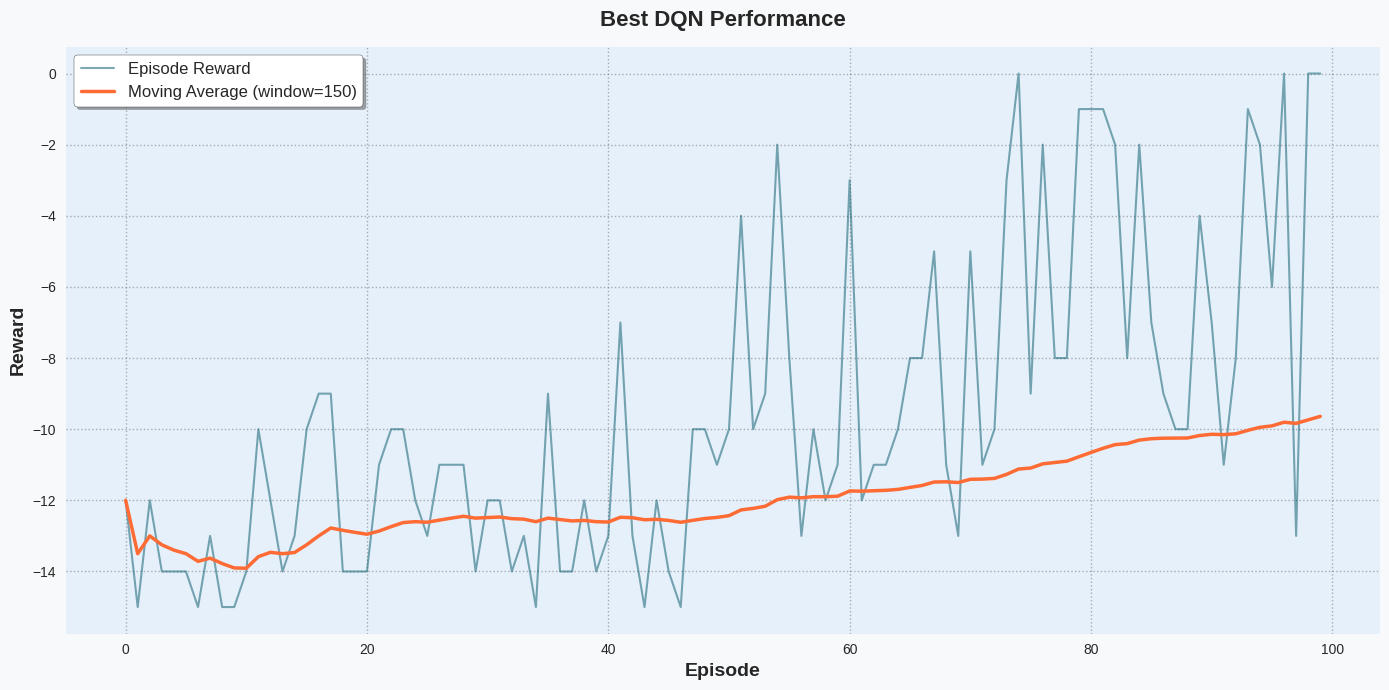


Training Best Double DQN Configuration...


Training Progress: 100%|██████████| 100/100 [15:35<00:00,  9.36s/it]


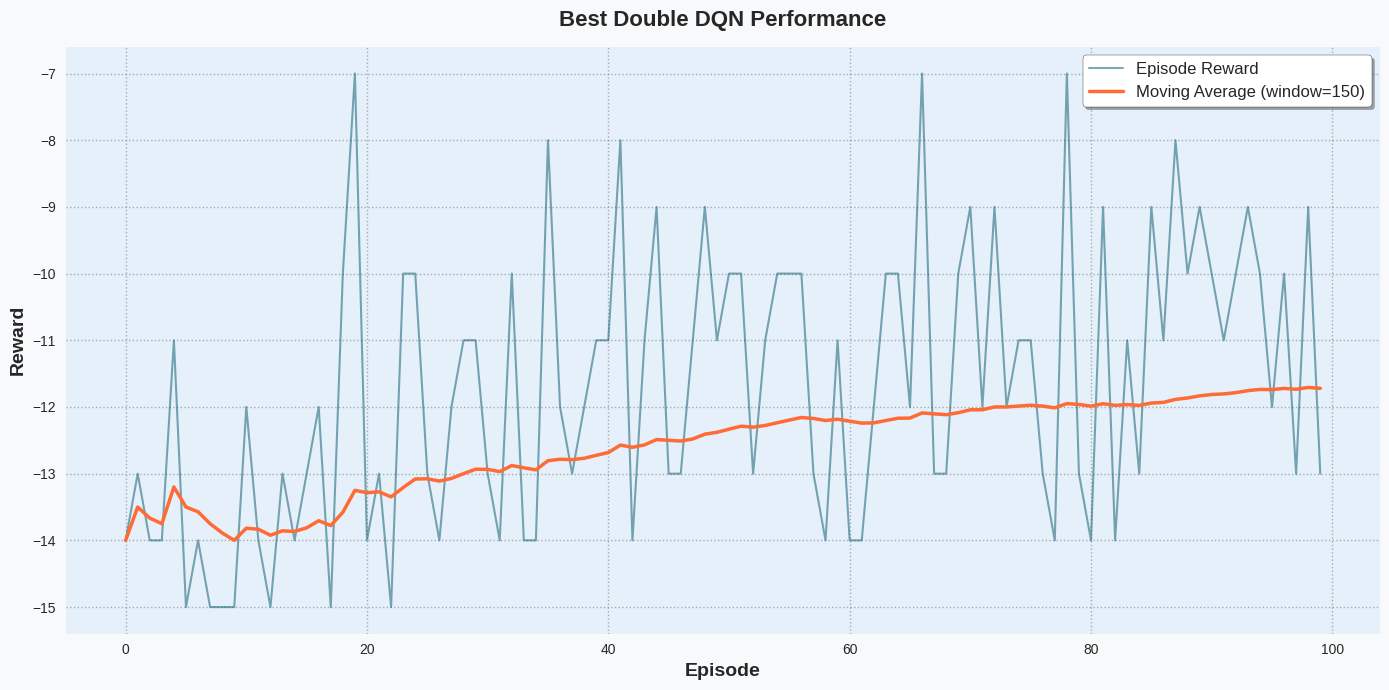


Comparison Results:
DQN - Mean Reward: -9.64, Std: 4.31
Double DQN - Mean Reward: -11.72, Std: 2.08


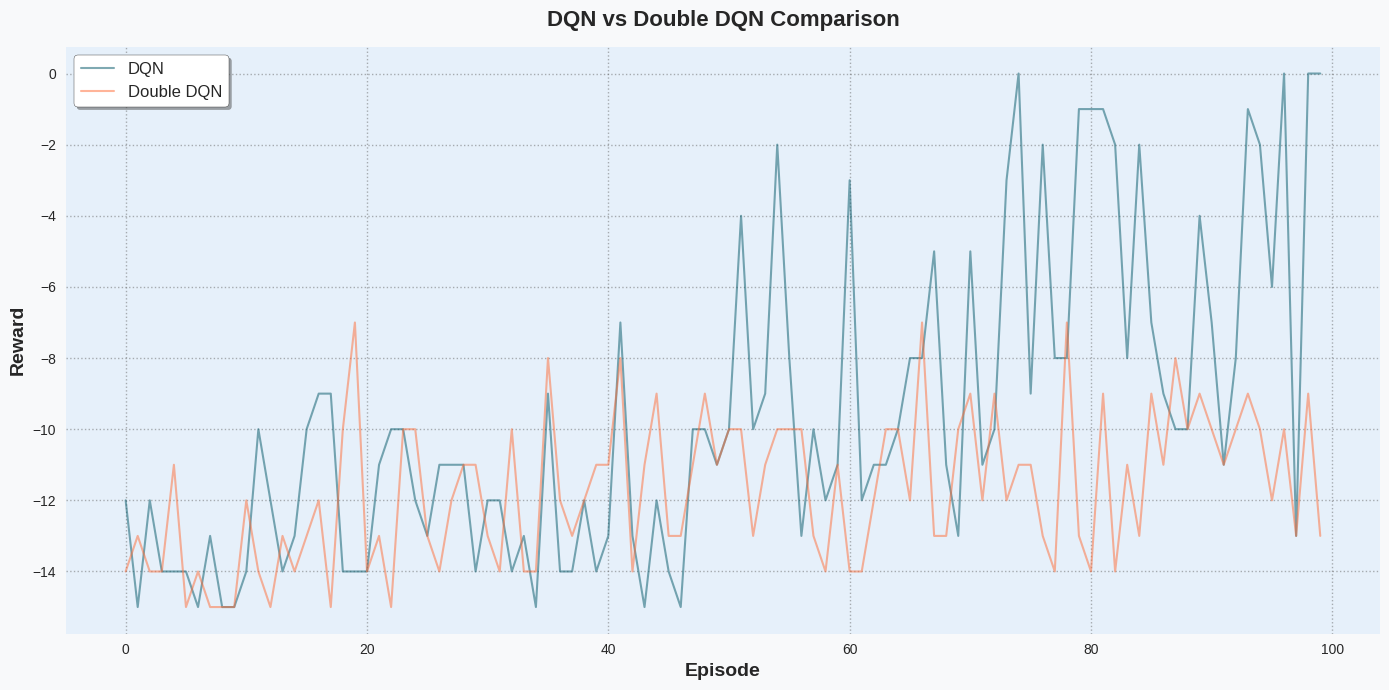

In [ ]:
if __name__ == "__main__":
    # Define best hyperparameters for comparison
    best_dqn_params = {'hidden_size': 256, 'learning_rate': 3e-4, 'epsilon_decay_steps': 15000, 'batch_size': 128}
    best_double_dqn_params = {'hidden_size': 256, 'learning_rate': 3e-4, 'epsilon_decay_steps': 15000, 'batch_size': 128, 'use_double_dqn': True}

    print("Running Part A: DQN Experiments")
    run_part_a()  # Execute DQN experiments

    print("\nRunning Part B: Double DQN Experiments")
    run_part_b()  # Execute Double DQN experiments

    print("\nRunning Part C: Comparison of Best DQN and Double DQN")
    run_part_c(best_dqn_params, best_double_dqn_params)  # Execute comparison